In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"milenayalliespinoza","key":"42a9999d96b5d78ecf7f33059abe3553"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d hongweicao/catanddogsmall
!unzip catanddogsmall.zip -d cats_and_dogs_small

Dataset URL: https://www.kaggle.com/datasets/hongweicao/catanddogsmall
License(s): unknown
 94% 115M/122M [00:01<00:00, 84.7MB/s]
100% 122M/122M [00:01<00:00, 88.1MB/s]
Archive:  catanddogsmall.zip
  inflating: cats_and_dogs_small/dogvscat_small/test/cats/1500.jpg  
  inflating: cats_and_dogs_small/dogvscat_small/test/cats/1501.jpg  
  inflating: cats_and_dogs_small/dogvscat_small/test/cats/1502.jpg  
  inflating: cats_and_dogs_small/dogvscat_small/test/cats/1503.jpg  
  inflating: cats_and_dogs_small/dogvscat_small/test/cats/1504.jpg  
  inflating: cats_and_dogs_small/dogvscat_small/test/cats/1505.jpg  
  inflating: cats_and_dogs_small/dogvscat_small/test/cats/1506.jpg  
  inflating: cats_and_dogs_small/dogvscat_small/test/cats/1507.jpg  
  inflating: cats_and_dogs_small/dogvscat_small/test/cats/1508.jpg  
  inflating: cats_and_dogs_small/dogvscat_small/test/cats/1509.jpg  
  inflating: cats_and_dogs_small/dogvscat_small/test/cats/1510.jpg  
  inflating: cats_and_dogs_small/dogvscat_s

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
# Verificar entorno de ejecución
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#Configurar el entorno de ejecución
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
#Importación de librerias
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pickle

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)


In [ ]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history.get('accuracy', []))
    acc = smooth_curve(history.history.get('accuracy', [])[:steps])
    val_acc = smooth_curve(history.history.get('val_accuracy', [])[:steps])
    loss = smooth_curve(history.history.get('loss', [])[:steps])
    val_loss = smooth_curve(history.history.get('val_loss', [])[:steps])

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), max(1, len(loss)//10)))
    plt.xlim(0, len(loss))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train Loss: {loss[-1]:.3f}, Val Loss: {val_loss[-1]:.3f}', fontsize=12)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), max(1, len(acc)//10)))
    plt.xlim(0, len(acc))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Train Accuracy: {acc[-1]:.3f}, Val Accuracy: {val_acc[-1]:.3f}', fontsize=12)
    plt.legend()

    plt.tight_layout()
    plt.show()

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    try:
        with open(fn, 'wb') as fw:
            pickle.dump(history.history, fw, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print(f"Error saving history: {e}")

def load_history(fn):
    class Temp:
        pass
    history = Temp()
    try:
        with open(fn, 'rb') as fr:
            history.history = pickle.load(fr)
    except Exception as e:
        print(f"Error loading history: {e}")
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount + 1, 2)
    return np.roll(np.roll(img, ox, axis=1), oy, axis=0), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, axis=1), -oy, axis=0)

def plot_image(img, title=''):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [ ]:

# Definir el modelo
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Directorios de datos
base_dir = '/content/cats_and_dogs_small/dogvscat_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
#Contar imágenes de entrenamiento y validación
def count_images(directory):
    count = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                count += 1
    return count

train_image_count = count_images(train_dir)
validation_image_count = count_images(validation_dir)
print(f"Number of training images: {train_image_count}")
print(f"Number of validation images: {validation_image_count}")

Number of training images: 2000
Number of validation images: 1000


In [ ]:
#Calcular los lotes por épocas
batch_size = 20
train_batches_per_epoch = train_image_count // batch_size
validation_batches_per_epoch = validation_image_count // batch_size
print(f"Number of batches per epoch for training: {train_batches_per_epoch}")
print(f"Number of batches per epoch for validation: {validation_batches_per_epoch}")

Number of batches per epoch for training: 100
Number of batches per epoch for validation: 50


In [ ]:
# Verificar que los directorios existan
for directory in [train_dir, validation_dir, test_dir]:
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directorio no encontrado: {directory}")

In [ ]:
!ls /content/cats_and_dogs_small/dogvscat_small

test  train  validation


In [ ]:
# Preparación de los generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=10,  # Número de lotes por época
    epochs=10,  # Número total de épocas
    validation_data=validation_generator,
    validation_steps=5,  # Número de lotes de validación por época
    verbose=1
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.5065 - loss: 0.7031 - val_accuracy: 0.4900 - val_loss: 0.6929
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4905 - loss: 0.6937 - val_accuracy: 0.4600 - val_loss: 0.6938
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5286 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4734 - loss: 0.6939 - val_accuracy: 0.4200 - val_loss: 0.6952
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5029 - loss: 0.6931 - val_accuracy: 0.4700 - val_loss: 0.6930
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.4821 - loss: 0.6933 - val_accuracy: 0.4800 - val_loss: 0.6931
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4898 - loss: 0.6933 - val_accuracy: 0.4200 - val_loss: 0.6951
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.4573 - loss: 0.6942 - val_accuracy: 0.5200 -

In [ ]:
model.save('model.keras')
save_history(history, 'history.bin')
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


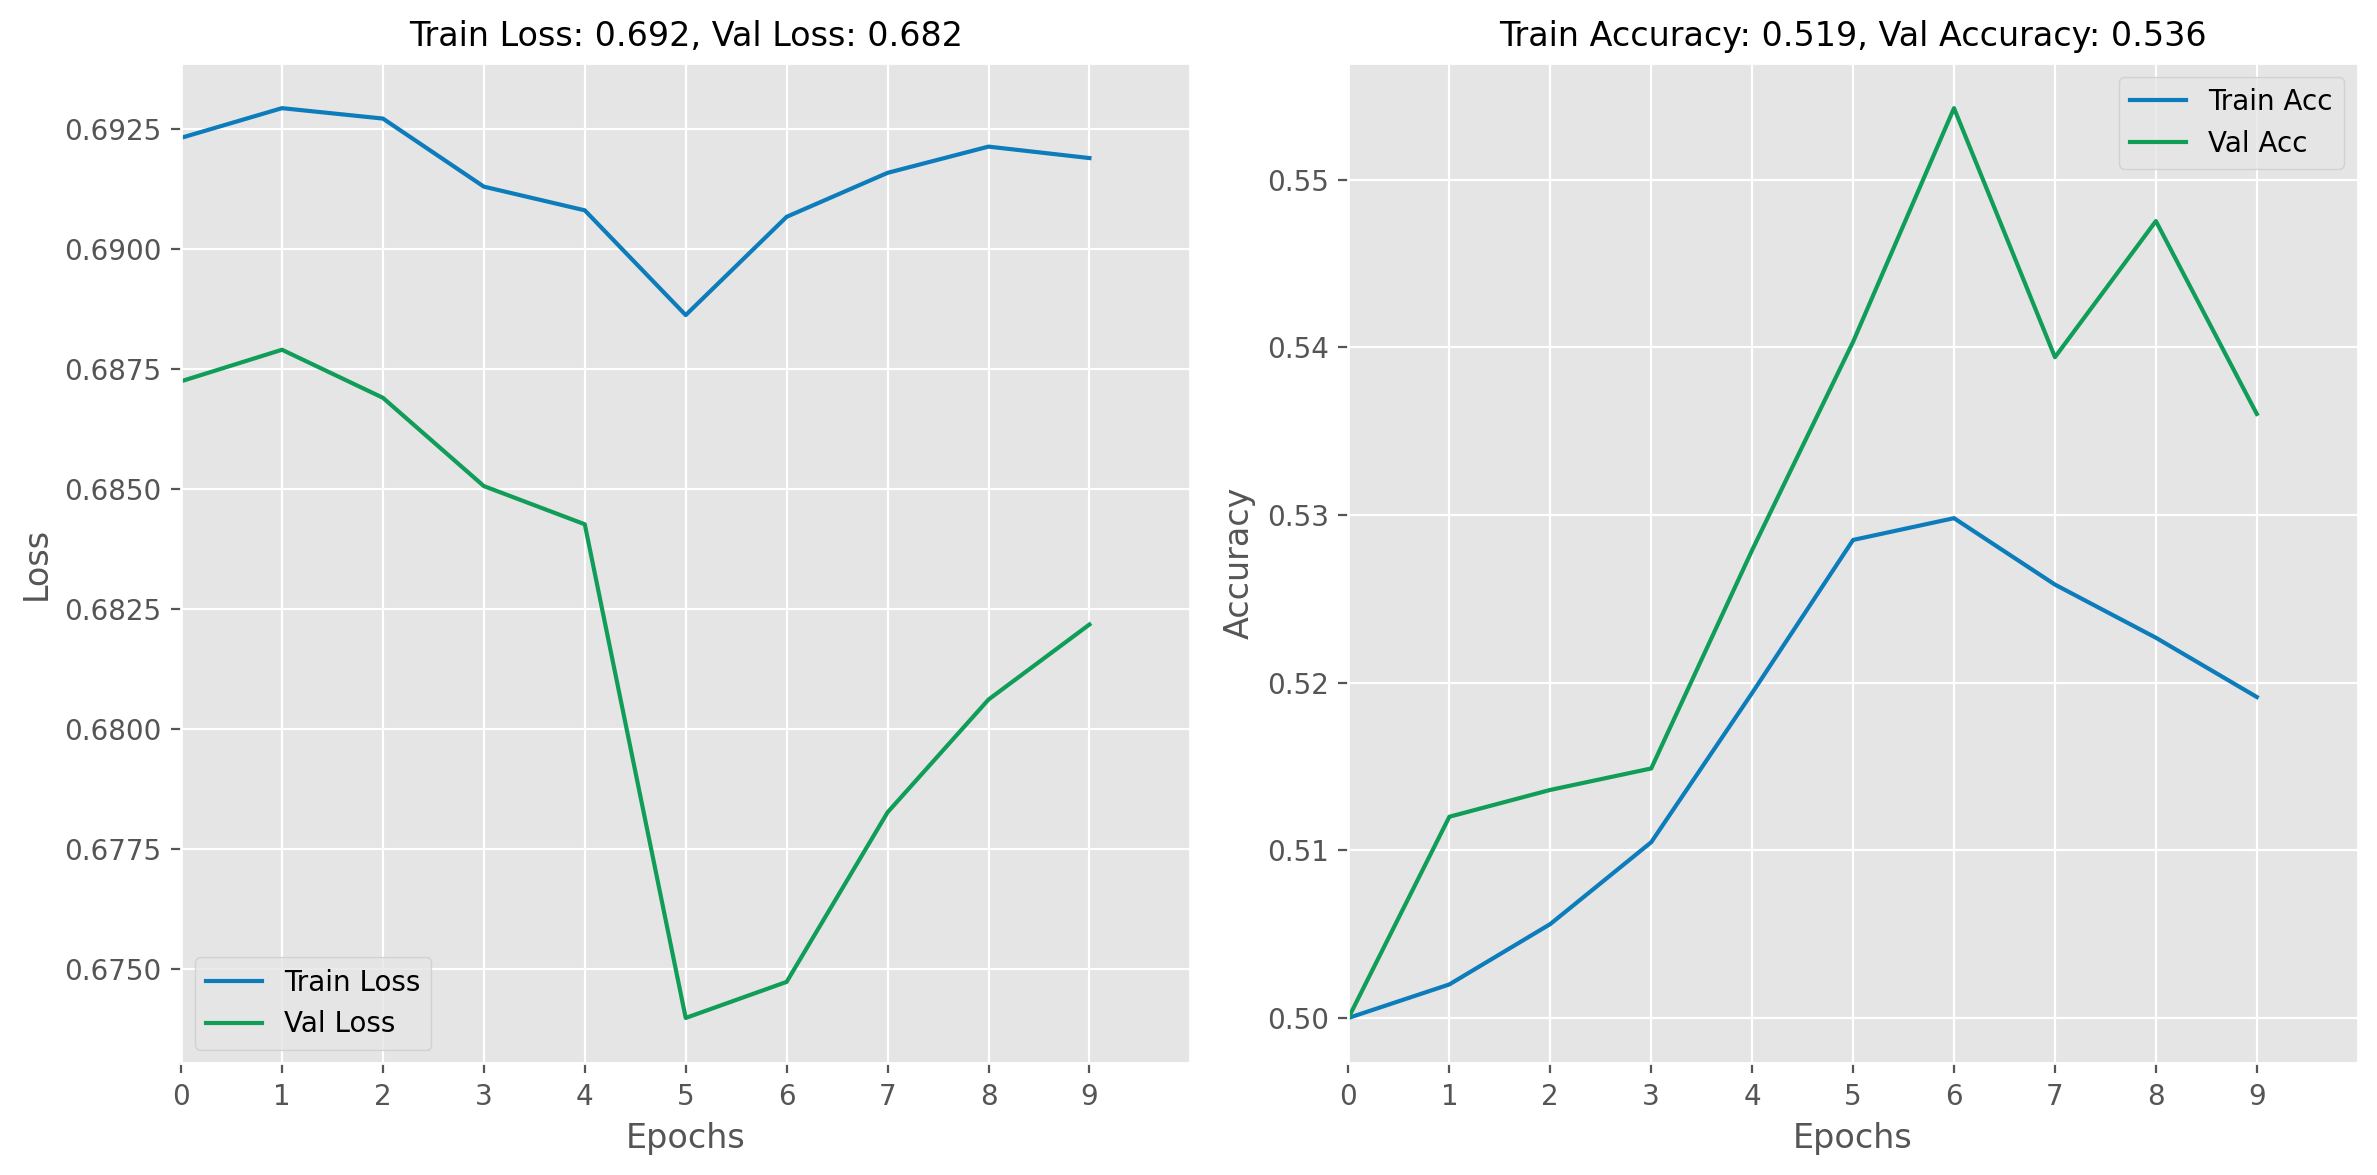

In [ ]:
history = load_history('history.bin')
plot_compare(history)

In [ ]:
model_aug = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2), name='maxpool_1'),
    Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'),
    MaxPooling2D((2, 2), name='maxpool_2'),
    Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'),
    MaxPooling2D((2, 2), name='maxpool_3'),
    Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'),
    MaxPooling2D((2, 2), name='maxpool_4'),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu', name='dense_1'),
    Dense(256, activation='relu', name='dense_2'),
    Dense(1, activation='sigmoid', name='output')
])

model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

In [ ]:
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
######################################### change the values 100, 60 and 50
history_aug = model_aug.fit(train_generator, steps_per_epoch=100, epochs=60,
                                      validation_data=validation_generator, validation_steps=50, verbose=1)
#history_aug = model_aug.fit(train_generator, steps_per_epoch=100, epochs=60,
#                                      validation_data=validation_generator, validation_steps=50, verbose=0)

Epoch 1/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.5081 - loss: 0.7090 - val_accuracy: 0.5530 - val_loss: 0.6810
Epoch 2/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.5445 - loss: 0.6875 - val_accuracy: 0.5060 - val_loss: 0.6917
Epoch 3/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.5275 - loss: 0.6914 - val_accuracy: 0.6010 - val_loss: 0.6798
Epoch 4/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.5541 - loss: 0.6855 - val_accuracy: 0.6090 - val_loss: 0.6590
Epoch 5/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.5464 - loss: 0.6855 - val_accuracy: 0.5990 - val_loss: 0.6641
Epoch 6/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.5570 - loss: 0.6792 - val_accuracy: 0.5430 - val_loss: 0.6808
Epoch 7/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.5874 - loss: 0.6727 - val_accuracy: 0.5700 - val_loss: 0.6783
Epoch 8/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.6209 - loss: 0

In [ ]:
model_aug.save('model_aug.keras')
save_history(history_aug, 'history_aug.bin')
print(history_aug.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


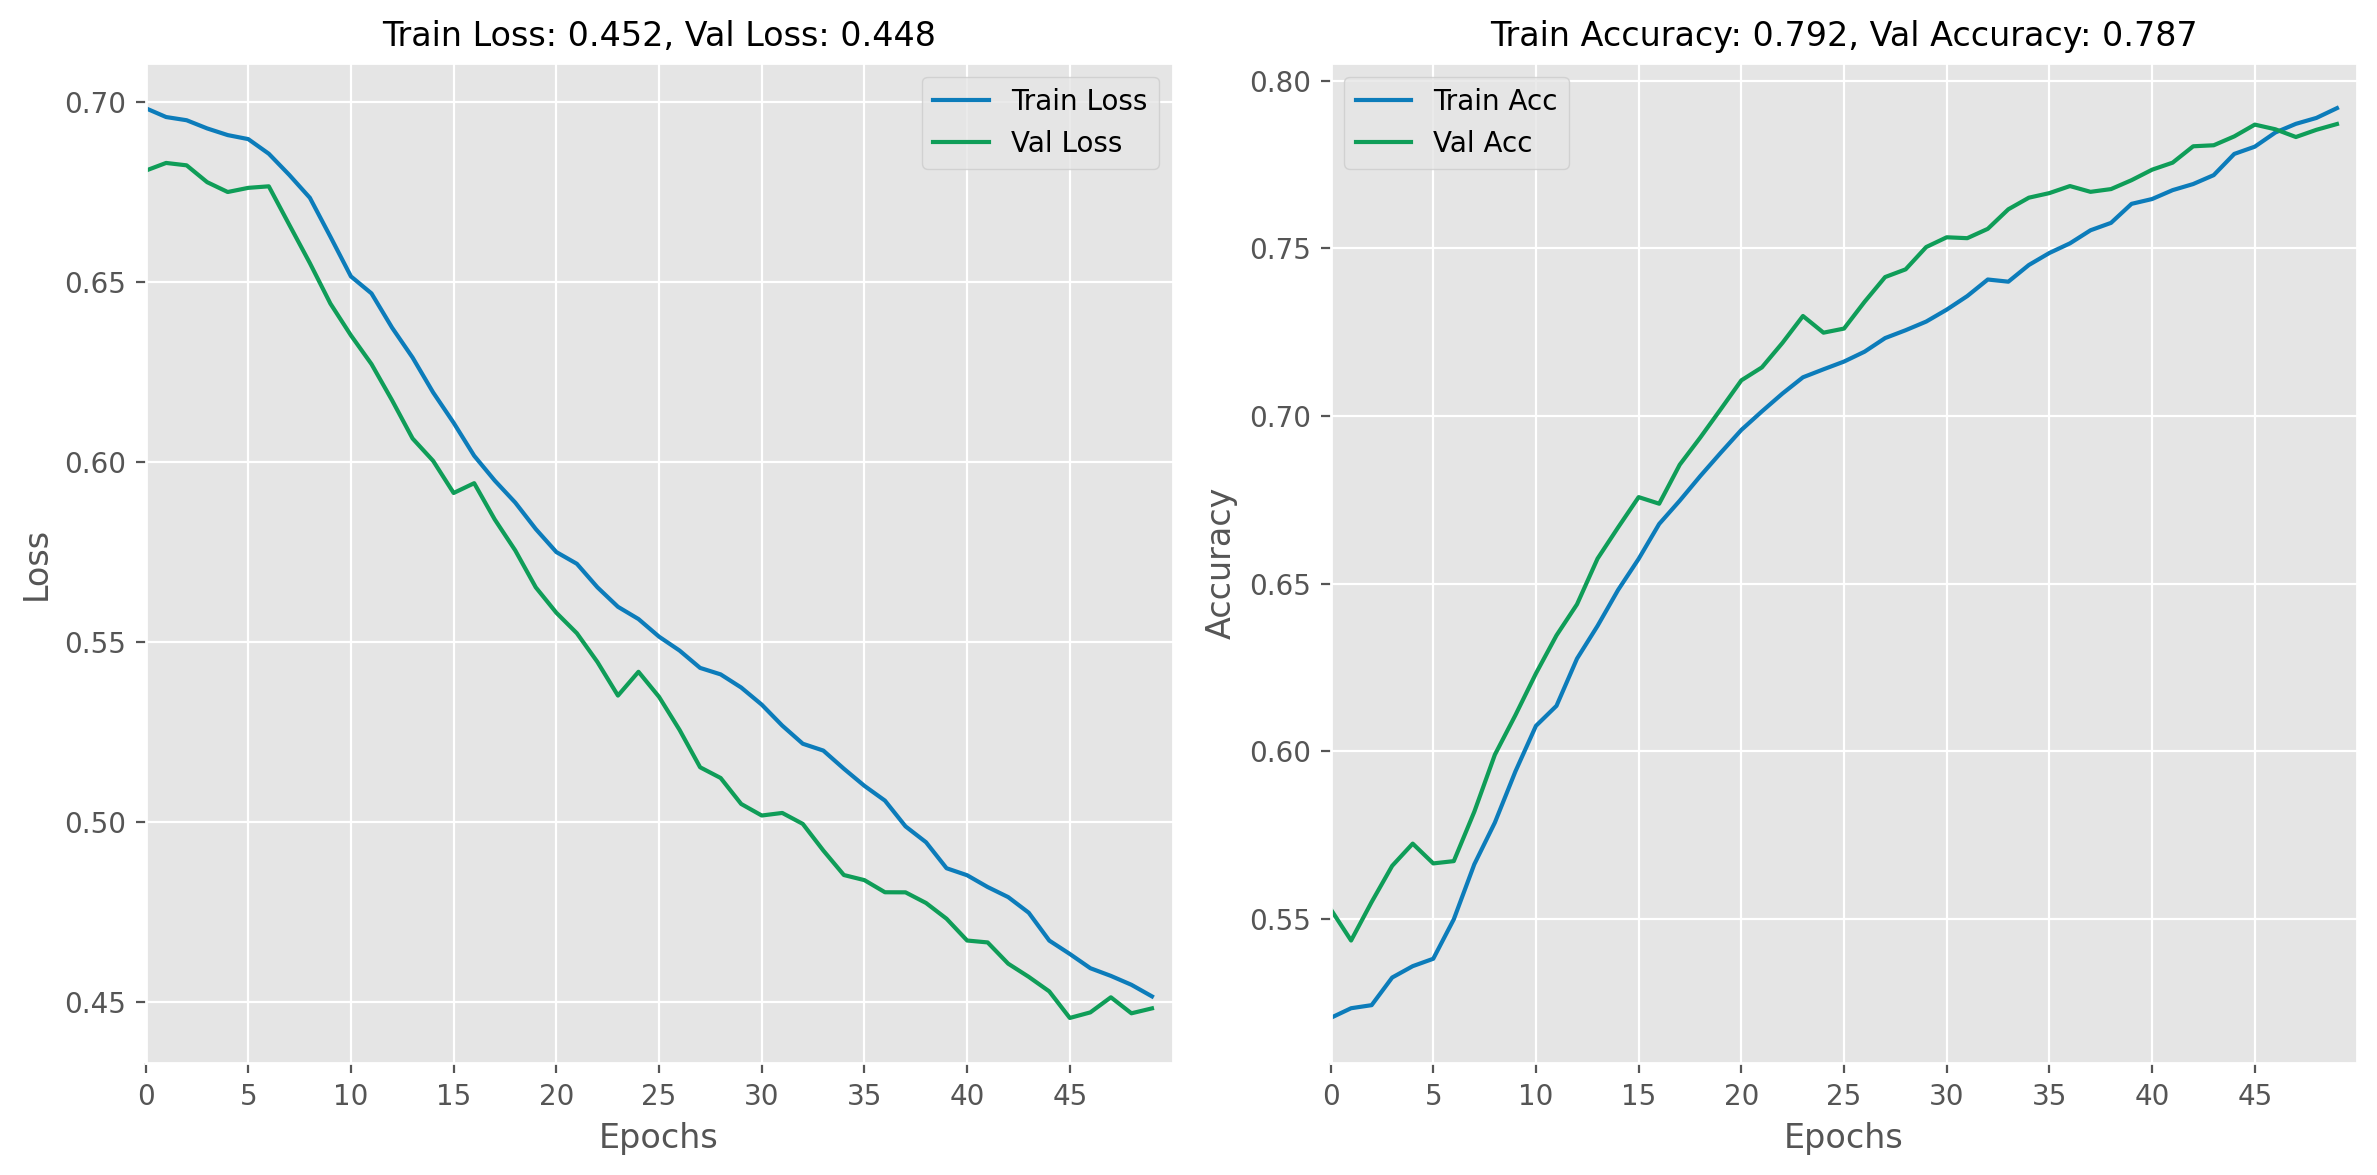

In [ ]:
history_aug = load_history('history_aug.bin')
plot_compare(history_aug, steps=50)

In [ ]:
# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5173 - loss: 0.6872
Validation Loss: 0.6887, Validation Accuracy: 0.5000


In [ ]:
# Realizar predicciones con el modelo
sample_image_path = '/content/cats_and_dogs_small/dogvscat_small/train/cats/53.jpg'
img = image.load_img(sample_image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale

In [ ]:
prediction = model.predict(img_array)
print(f'Predicción: {"Perro" if prediction[0] > 0.5 else "Gato"}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
Predicción: Gato


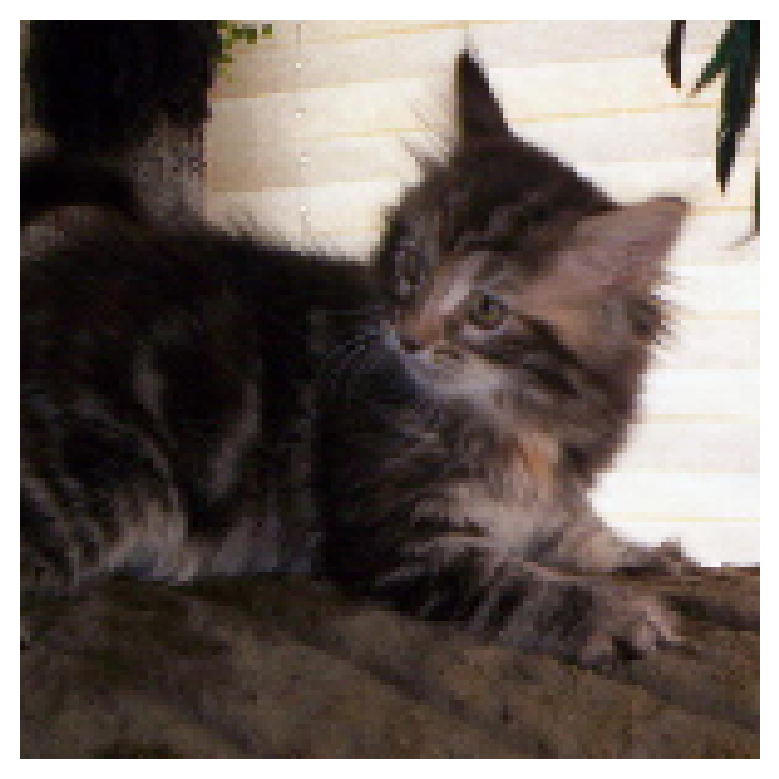

In [ ]:
plt.imshow(img_array[0])
plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16

# Load the VGG16 model with ImageNet weights, without the top classification layer
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


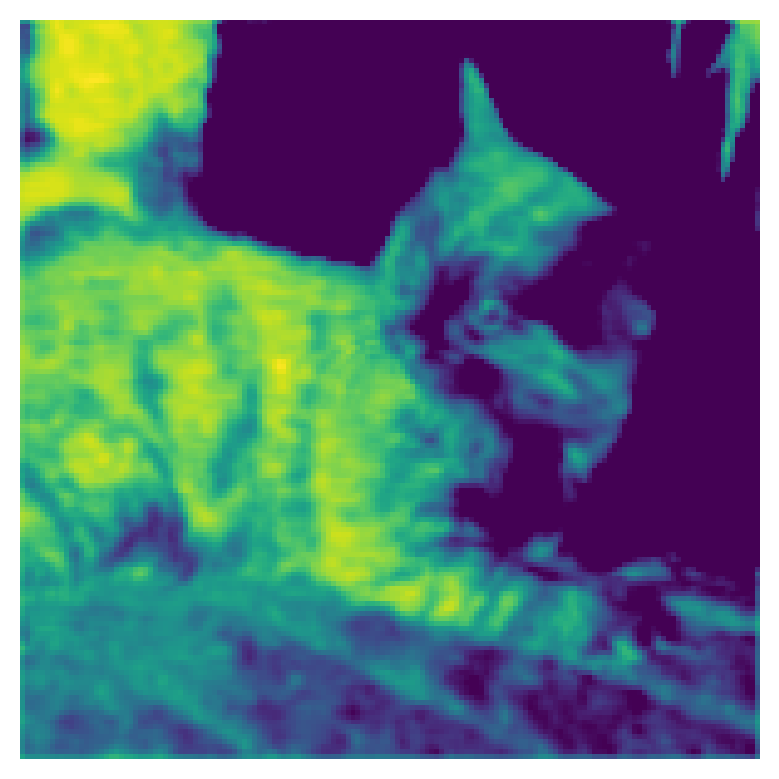

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load the VGG16 model with ImageNet weights, without the top classification layer
vgg = VGG16(weights='imagenet', include_top=False)

# Extract the outputs of the convolutional layers
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]

# Create a new model that outputs the features from the specified layers
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)

# Assuming img_tensor is the preprocessed image tensor
intermediate_activations = activation_model.predict(img_array)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


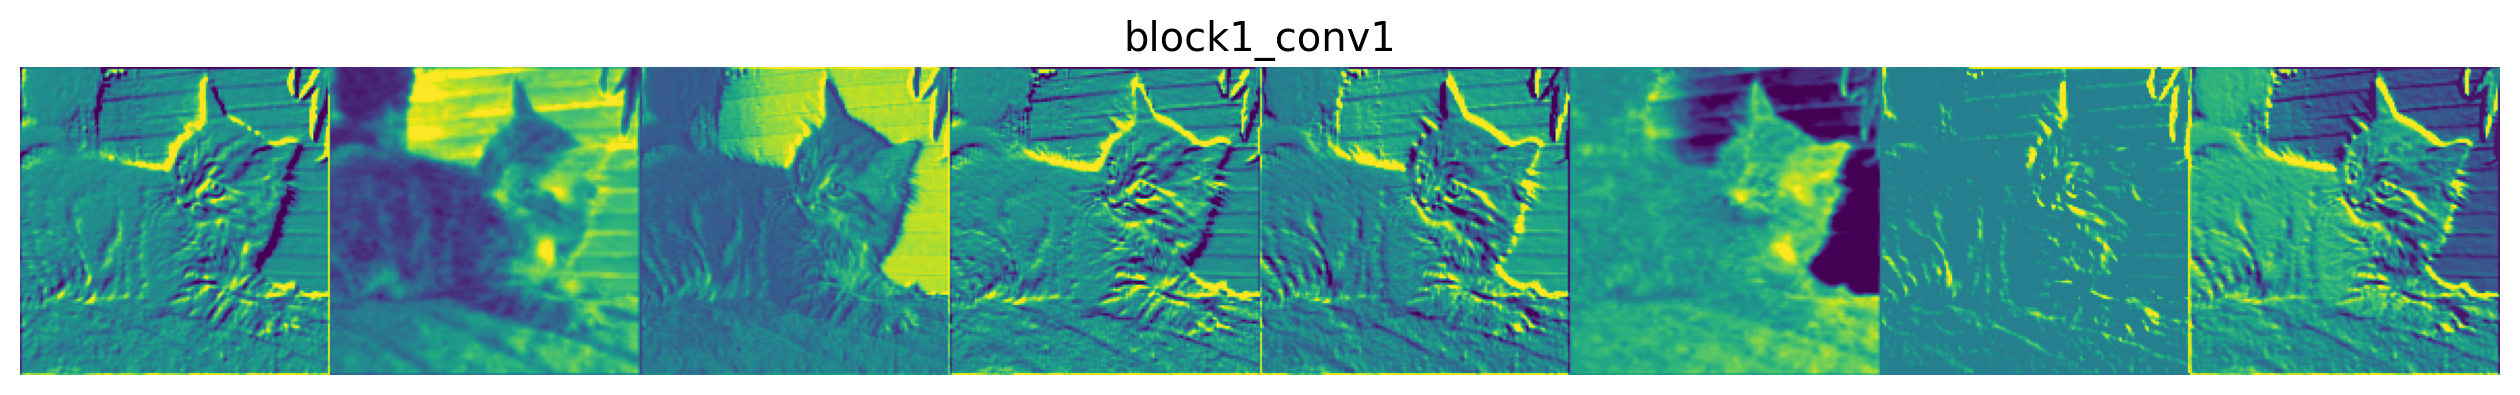

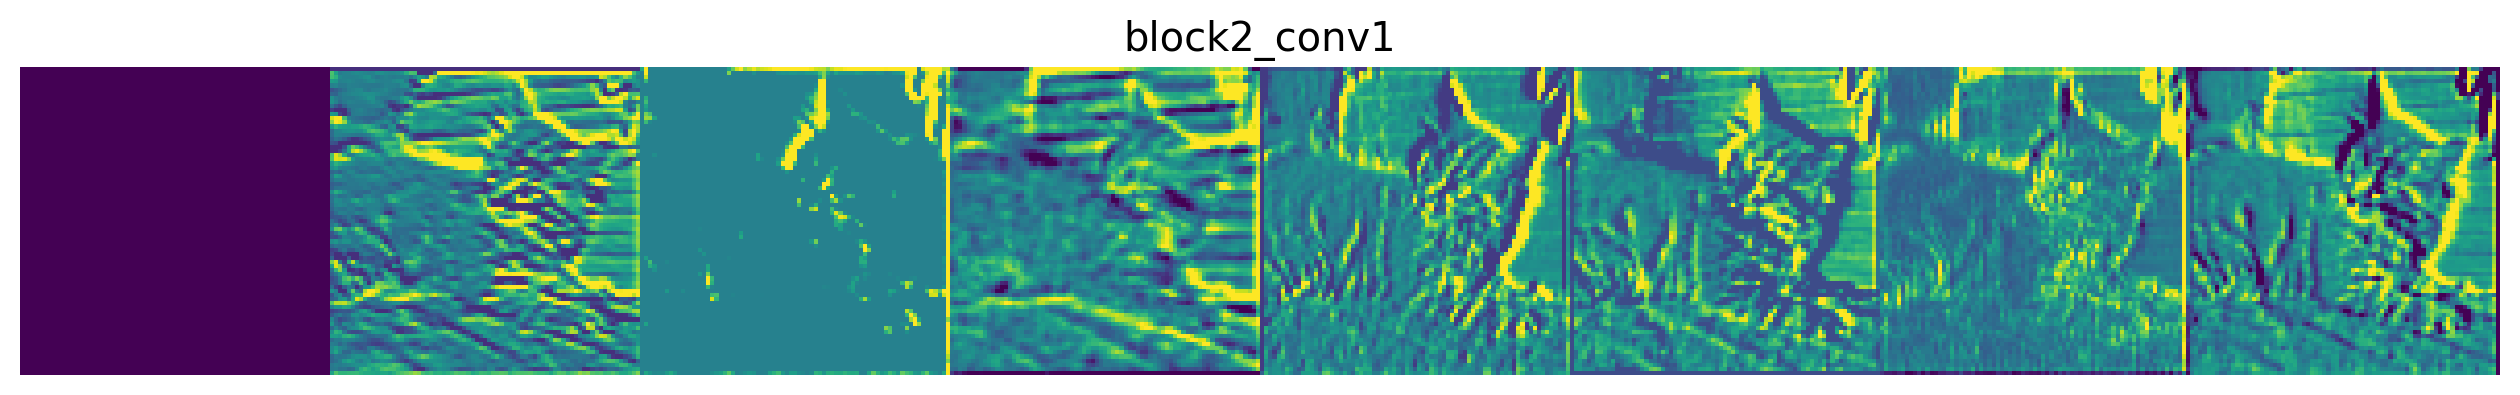

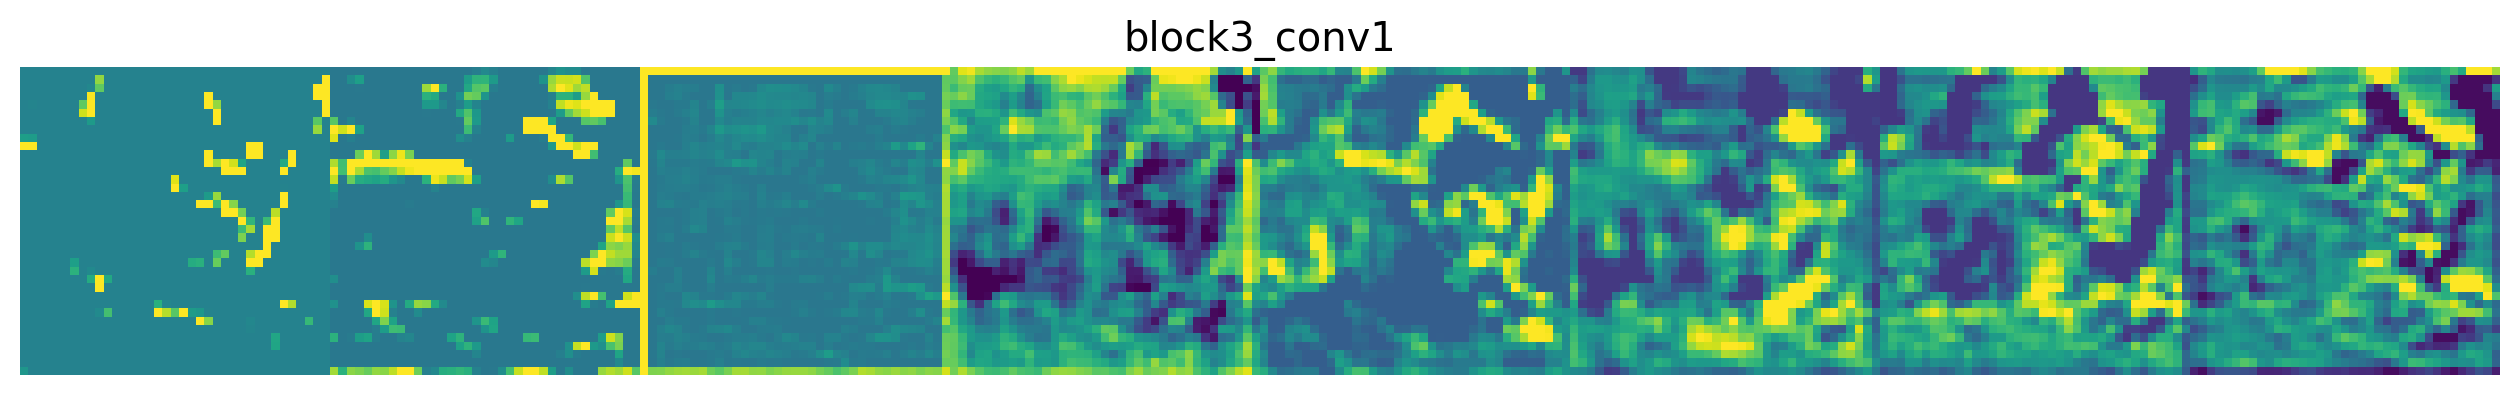

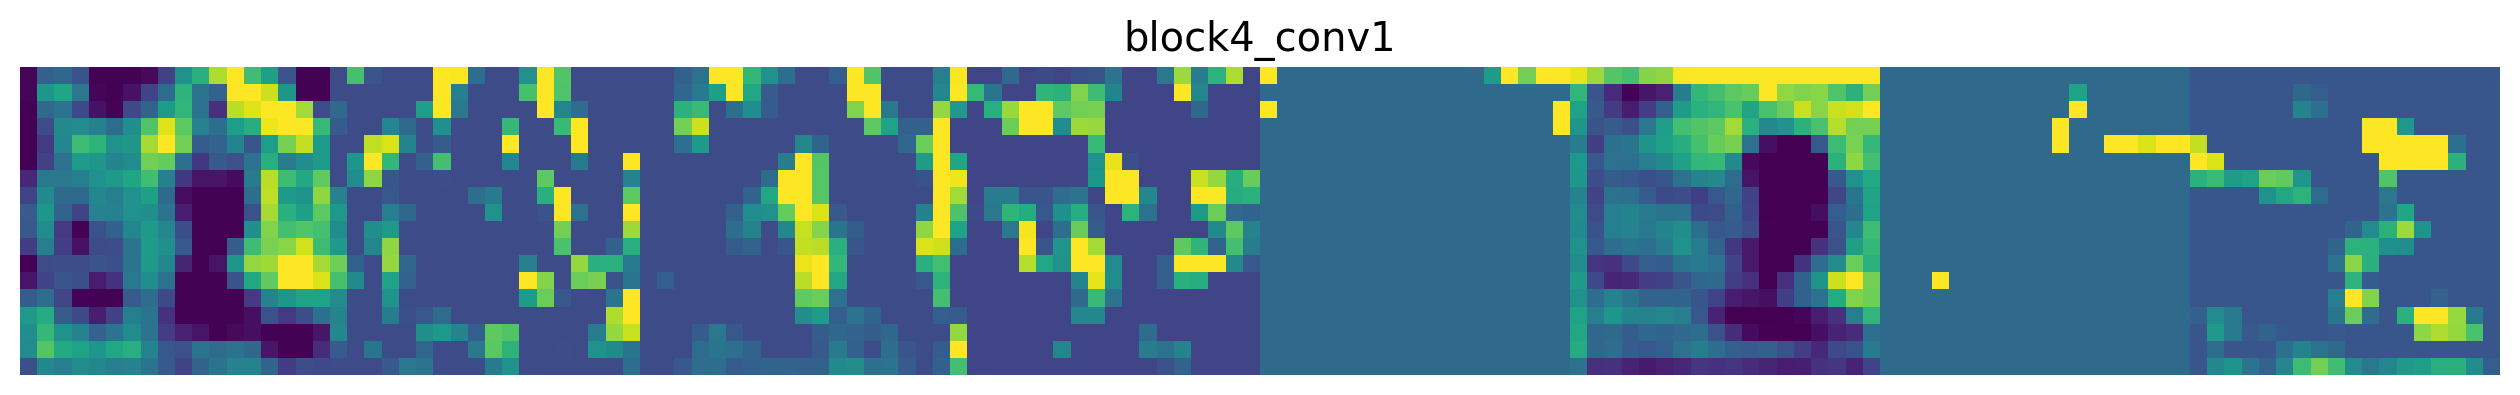

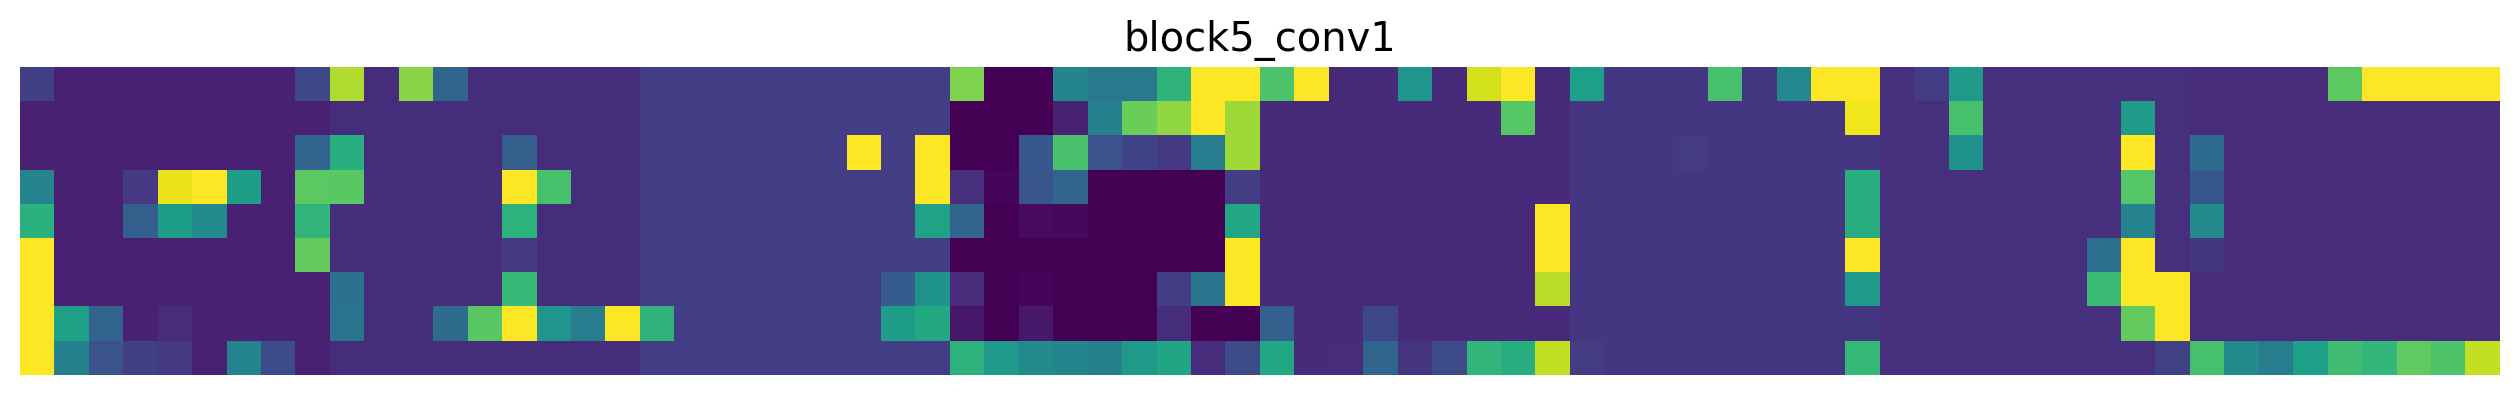

In [ ]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_array)

images_per_row = 8
max_images = 8
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

In [ ]:
# Cargar el modelo VGG16 con pesos preentrenados de ImageNet
model = VGG16(weights='imagenet', include_top=True)

# Buscar el índice de la capa 'predictions' por nombre
layer_idx = None
for i, layer in enumerate(model.layers):
    if layer.name == 'predictions':
        layer_idx = i
        break

if layer_idx is None:
    raise ValueError("Layer 'predictions' not found in the model.")

# Cambiar la activación softmax a lineal
model.layers[layer_idx].activation = activations.linear

In [ ]:
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.callbacks import Print

# Definir la función de pérdida para maximizar la activación del filtro 20
def loss(output):
    return output[:, 20]

# Configurar la visualización de activaciones
activation_maximization = ActivationMaximization(model, model_modifier=None, clone=False)

# Visualizar la activación del filtro (por ejemplo, el filtro 20)
img = activation_maximization(loss, callbacks=[Print(interval=50)])

# Mostrar la imagen generada
plot_image(img[0])


Steps: 050	Scores: [[35.759098052978516]],	Regularization: [('TotalVariation2D', [4.228952884674072]), ('Norm', [38.12898635864258])]
Steps: 100	Scores: [[83.4642562866211]],	Regularization: [('TotalVariation2D', [4.679251194000244]), ('Norm', [38.08654022216797])]
Steps: 150	Scores: [[113.64705657958984]],	Regularization: [('TotalVariation2D', [5.2183332443237305]), ('Norm', [38.077449798583984])]


In [ ]:
from tf_keras_vis.utils.modifiers import Jitter

# Definir la función de pérdida para maximizar la activación del filtro 20 (ouzel)
def loss(output):
    return output[:, 20]  # 20 es la categoría de ImageNet para 'ouzel'

# Configurar la visualización de activaciones con jitter
activation_maximization = ActivationMaximization(model, model_modifier=None, clone=False)

# Aplicar jitter de 16 píxeles durante el proceso de optimización
img = activation_maximization(
    loss,
    callbacks=[Print(interval=50)],
    input_modifiers=[Jitter(16)],  # Jitter de 16 píxeles
    steps=400  # Número de iteraciones para optimizar
)

# Mostrar la imagen generada
plot_image(img[0])